<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Gradient Descent Code-Along

Let's walk through how gradient descent works using code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The objective function
def f(x):
    return -np.log(x) / (1 + x)

In [3]:
# Derivative of the objective function
def f_deriv(x):
    return -(1 + 1/x - np.log(x)) / (1 + x)**2

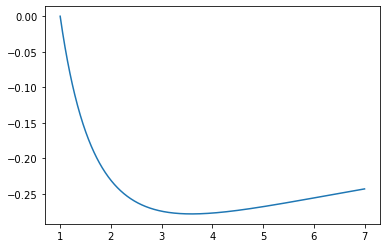

In [4]:
# Let's see what it looks like
xs = np.linspace(1, 7, 1000)
plt.plot(xs, f(xs));

In [5]:
# Initial value and learning rate
x = 1
alpha = 1
num_steps = 300

# Iterate and apply gradient descent
x_steps = [x]
for i in range(num_steps):
    x = x - alpha * f_deriv(x)
    x_steps.append(x)

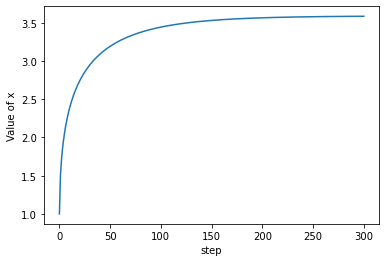

In [6]:
plt.plot(x_steps)
plt.xlabel('step')
plt.ylabel('Value of x');
# You can see here that the value of x that is optimum is pretty much converging to ~3.5
# This aligns with the min value of the plot above!

## Let's see if we can do OLS by Gradient Descent!

In [7]:
# Set a random seed.
np.random.seed(42)

In [8]:
# Let's generate a fake linear regression dataset of the form y = beta_0 + beta_1 * x + error
# Just to make this more fun, let's use a Poisson distribution for our x!

# Our Fake Linear Equation
beta_0 = 200_000
beta_1 = 1000
x = np.random.poisson(45, 100)
error = np.round(np.random.normal(0, 20000, 100))

# Our Equation
y_true = beta_0 + (beta_1 * x) + error
print(y_true)

[233070. 267128. 241282. 222085. 255464. 245706. 223323. 247075. 248164.
 218141. 251156. 249216. 268661. 268076. 213447. 230243. 246301. 250276.
 251301. 323055. 269418. 269711. 253080. 242028. 236695. 267179. 224543.
 232264. 241293. 250637. 297293. 204655. 266725. 209746. 231561. 271779.
 256286. 214445. 235694. 264592. 230393. 245329. 256911. 229968. 281879.
 253678. 216497. 251729. 238764. 272049. 225150. 236705. 253100. 253315.
 234994. 238310. 253501. 231933. 275309. 255100. 204782. 274357. 279443.
 268649. 208613. 232315. 273338. 219847. 249876. 264493. 226461. 246809.
 184175. 237512. 236949. 215044. 284648. 217397. 246199. 244615. 276825.
 218283. 258263. 246205. 228370. 258242. 244981. 235996. 249396. 226294.
 242270. 268243. 282720. 221244. 280661. 200958. 244964. 267766. 249620.
 228546.]


In [9]:
# Create dataframe
df = pd.DataFrame({'x': x, 'y_true': y_true})

print(df.shape)
df.head()

(100, 2)


,x,y_true
0,42,233070.0
1,50,267128.0
2,37,241282.0
3,47,222085.0
4,52,255464.0


#### Our goal is to fit a model here.
- You and I know that our $y$-intercept $\beta_0$ is 200,000.
- You and I know that our slope $\beta_1$ is 1,000.
- However, our computer does not know that. Our computer has to estimate $\hat{\beta}_0$ and $\hat{\beta}_1$ from the data.
    - We might say that our **machine** has to... **learn**.

#### Our workflow:
1. Instantiate model.
2. Select a learning rate $\alpha$.
3. Select a starting point $\hat{\beta}_{1,0}$.
4. Calculate the gradient of the loss function.
5. Calculate $\hat{\beta}_{1,i+1} = \hat{\beta}_{1,i} - \alpha * \frac{\partial L}{\partial \beta_1}$.
6. Check value of $\left|\hat{\beta}_{1,i+1} - \hat{\beta}_{1,i}\right|$.
7. Repeat steps 4 through 6 until "stopping condition" is met.

#### Step 1. Instantiate model.

Our model takes on the form:
$$ Y = \beta_0 + \beta_1 X + \varepsilon$$

#### Step 2. Select a learning rate $\alpha$.

$$\alpha = 0.1$$

In [10]:
alpha = 0.1

#### Step 3. Select a starting point.
The zero-th iteration of $\hat{\beta}_1$ is going to start at, say, 20.
$$\hat{\beta}_{1,0} = 20$$

Two points:
- You and I know that the true value of $\beta_1$ is 1000. We need the computer to figure (machine to learn) that part out!
- We're going to pretend like the computer already knows the value for $\beta_0$. In reality, we'd have to do this for $\beta_0$ and for $\beta_1$ at the same time.

In [11]:
# Pick any random number, it doesn't matter!
beta_1 = 20

#### Step 4. Calculate the gradient of the loss function with respect to parameter $\beta_1$.

The loss function, $L$, is our mean square error.

$$L = \frac{1}{n}\sum_{i = 1} ^ n (y_i - \hat{y}_i)^2 $$

$$\Rightarrow L = \frac{1}{n}\sum_{i = 1} ^ n \left(y_i - \left(\hat{\beta}_0 + \hat{\beta}_1x_i\right)\right)^2 $$

The gradient of this loss function with respect to $\beta_1$ is:

$$\frac{\partial L}{\partial \beta_1} = {2}\frac{\sum_{i=1}^n -x_i\left(y_i - \left(\hat{\beta}_1x_i + \hat{\beta}_0\right)\right)}{n} $$

In [12]:
# Calculate gradient of beta_1.
def beta_1_gradient(x, y, beta_1, beta_0):
    grads = -x * (y - (beta_1*x + beta_0))
    return 2 * np.mean(grads)

#### Step 5. Calculate $\hat{\beta}_{1,i+1} = \hat{\beta}_{1,i} - \alpha * \frac{\partial L}{\partial \beta_1}$.

In [16]:
# Define function to calculate new value of beta_1.
def update_beta_1(beta_1, alpha, gradient):
    beta_1 = beta_1 - alpha * gradient
    return beta_1

#### Step 6. Check value of $\left|\hat{\beta}_{1,i+1} - \hat{\beta}_{1,i}\right|$. 
We want to stop the iterations once the difference is less than a tolerance value

In [17]:
def check_update(beta_1, updated_beta_1, tolerance = 0.1):
    return abs(beta_1 - updated_beta_1) < tolerance

#### Step 7: Save final value of $\hat{\beta}_1$.

#### Putting it all together...

In [18]:
def gradient_descent(x, y, beta_1 = 0, alpha = 0.01, max_iter = 100):
    # Set converged = False.
    converged = False
    
    # Iterate through our observations.
    step = 0
    while not converged:
        
        # Calculate gradient.
        gradient = beta_1_gradient(x, y, beta_1, 200000)
        
        # Update beta_1.
        updated_beta_1 = update_beta_1(beta_1, alpha, gradient)
        
        # Check for convergence.
        converged = check_update(beta_1, updated_beta_1)
        
        # Overwrite beta_1.
        beta_1 = updated_beta_1
        
        # Print out current step findings.
        print(f'Iteration {step} with beta_1 value of {beta_1}.')
        
        # If we've converged, let us know!
        if converged:
            print(f'Our algorithm converged after {step} iterations with a beta_1 value of {beta_1}.')
        else:
            step += 1
            
        # If we exceed our step limit, break!
        if step > max_iter:
            break
        
    # If we didn't converge by the end of our loop, let us know!
    if not converged:
        print("Our algorithm did not converge, so do not trust the value of beta_1.")
    
    # Return beta_1.
    return beta_1

In [19]:
# Call gradient_descent with an initial beta_1 of 20, alpha of 0.01, and 100 iterations.
gradient_descent(df['x'],
                 df['y_true'],
                 beta_1 = 20,
                 alpha = 0.01,
                 max_iter = 100)

Iteration 0 with beta_1 value of 41435.536400000005.
Iteration 1 with beta_1 value of -1644889.1423060796.
Iteration 2 with beta_1 value of 67017530.06550508.
Iteration 3 with beta_1 value of -2728723925.3027844.
Iteration 4 with beta_1 value of 111106040061.21902.
Iteration 5 with beta_1 value of -4523926812130.787.
Iteration 6 with beta_1 value of 184201632837141.66.
Iteration 7 with beta_1 value of -7500174724514217.0.
Iteration 8 with beta_1 value of 3.0538611429303245e+17.
Iteration 9 with beta_1 value of -1.2434467492892217e+19.
Iteration 10 with beta_1 value of 5.06296699801591e+20.
Iteration 11 with beta_1 value of -2.0614983985161335e+22.
Iteration 12 with beta_1 value of 8.39384425920612e+23.
Iteration 13 with beta_1 value of -3.4177383547094743e+25.
Iteration 14 with beta_1 value of 1.391607361363766e+27.
Iteration 15 with beta_1 value of -5.666235525412072e+28.
Iteration 16 with beta_1 value of 2.3071324513530843e+30.
Iteration 17 with beta_1 value of -9.393997344823376e+31

3.840754664400018e+165

<details><summary>What should we do?</summary>

- We **should not** adjust our maximum iterations. It doesn't look like we'll converge.
- We should adjust our alpha!
</details>

In [20]:
gradient_descent(df['x'],
                 df['y_true'],
                 beta_1 = 20,
                 alpha = 0.0001,
                 max_iter = 100)

# try changing the initial value of beta_1 from 20 to whatever number
# The algorithm will still find a value of beta_1 very close to the actual value of 1000

Iteration 0 with beta_1 value of 434.155364.
Iteration 1 with beta_1 value of 675.5367064893921.
Iteration 2 with beta_1 value of 816.2205115697996.
Iteration 3 with beta_1 value of 898.2149723172032.
Iteration 4 with beta_1 value of 946.003639885691.
Iteration 5 with beta_1 value of 973.8562134272975.
Iteration 6 with beta_1 value of 990.089473159405.
Iteration 7 with beta_1 value of 999.5506714625496.
Iteration 8 with beta_1 value of 1005.0649227471749.
Iteration 9 with beta_1 value of 1008.2787827948905.
Iteration 10 with beta_1 value of 1010.1519104187804.
Iteration 11 with beta_1 value of 1011.2436216455569.
Iteration 12 with beta_1 value of 1011.8799015164366.
Iteration 13 with beta_1 value of 1012.2507432410217.
Iteration 14 with beta_1 value of 1012.4668801816782.
Iteration 15 with beta_1 value of 1012.5928508425271.
Iteration 16 with beta_1 value of 1012.6662700708484.
Our algorithm converged after 16 iterations with a beta_1 value of 1012.6662700708484.


1012.6662700708484

# Conclusion
- The value of $\hat{\beta_1}$ at the end of gradient descent is 1012 which is so close to the actual value of 1000. 
- Even though we started the gradient descent algorithm with a random $\hat{\beta_1}=20$, it was still able to find a value very close to the true value almost instantaneously on modern computers!
- In reality, we would have to concurrently run gradient descent for all our parameters $\hat{\beta_1}$ and $\hat{\beta_0}$
- Implement gradient descent in code is an interview question! As a test for yourself, try writing code to change both $\hat{\beta_1}$ and $\hat{\beta_0}$ in the gradient descent loop!
- As already mentioned, Gradient descent is the basis of the modern AI revolution especially when we're talking about deep learning. And Gradient descent is just the clever application of math that was invented several centuries back! [See: Who's the greatest mathematician/physicist in the history of human civilization?](https://www.youtube.com/watch?v=danYFxGnFxQ)

<details><summary>Here's a meme to drive home that point!</summary>

<img src='assets/math.jpeg'>
</details>